## Lessons Learned & Creating a Stable Diffusion Pipeline

Historically, I've moved relatively quickly through any self-paced tutorials or classes that I've taken. I feel like I get the concepts, and can implement them in a few test cases, then it's on to the next thing.

<br>
This hasn't been an ideal approach.
<br>
<br>
About 3 years ago I convinced my boss to transition the firm from AutoCAD to Revit for all our projects, mostly so that I'd never have to type out a window schedule by hand again. Neither of us had ever touched it, and at the time the firm consisted of just myself and my boss.
<br>
<br>
I won't bore you with the specifics, but after many tutorials and a decent amount of time wrestling with it, we had fully made the jump, and I was feeling really comfortable with my level of proficiency.
<br>
<br>
It wasn't until we started training new hires to use it that I realized I had missed some foundational understanding of how the program worked under the hood. I could make it do the things I wanted, but I couldn't quite explain why right off the bat. 
<br>
<br>
Explaining it to someone else truly deepened my own comprehension and improved my workflow and understanding of what it could do significantly. 
<br>
<br>
So, with that in mind I'm going to try to get ahead of that curve and do the same thing here. In future posts I hope to revisit and maybe refactor some of my old code from the first part of the course, but for the moment we're going to hop in where I'm at:


### Creating a Stable Diffusion Pipeline from Components

In [1]:
# !pip install -Uq diffusers transformers fastcore

In [2]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

import logging

logging.disable(logging.WARNING) # <1>
torch.manual_seed(1);

1. While quite helpful in any other situation, huggingface warnings will make this notebook fairly ugly, so for the time being, we're disabling it.

#### CLIP Tokenizer and Text Encoder

First we're going to load in a `text_encoder` and `tokenizer`. These are from the text portion of a CLIP model, and we're going to use the weights available from OpenAI.<br>
<br>
These will handle tokenizing our text and allow us to get the embeddings for our text prompt.

In [3]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

#### VAE and UNET

The next step is to load in our `vae` and `unet`. 

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [5]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

#### Scheduling

Next we'll have to add a `scheduler`. The `scheduler` creates a schedule by:
- Defining the number of noising steps
- Defining the amount of noise added at each step
<br>

These are derived from the *beta* parameters, which we'll pass in below
<br>
It's important to note that when scheduling, we have to make sure to use the same noising schedule that was used during training

In [6]:
from diffusers import LMSDiscreteScheduler

In [7]:
scheduler = LMSDiscreteScheduler(num_train_timesteps=1000, beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")

#### Parameters for Generation

We're now going to define the parameters that we'll use for generation

In [8]:
prompt = ["a photograph of a beautiful mountain landscape"]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

#### Tokenizing the Prompt

Next we're going to tokenize the prompt using our `tokenizer`. 
<br>
<br>
The model is going to require the same number of tokens for every prompt to optimize processing on the GPU. The GPU generally likes matrices to be the same size, so I have a feeling this is something that's going to be a recurring theme for optimization.

In [9]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, 
    truncation=True, return_tensors="pt"
)

In [10]:
text_input['input_ids']

tensor([[49406,   320,  8853,   539,   320,  1215,  3965,  5727, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

Above are our tokens, with each number representing our input, with the exception of *49407*, which is our *padding*

In [11]:
tokenizer.decode(49407)

'<|endoftext|>'

As illustrated above, our padding is just an **'<|endoftext|>'** marker

And if we look at the `attention_mask`, we can see that it's doing its job by representing our padding tokens that we're not interested in as 0's

In [12]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

#### Getting Text Embeddings

Now we can get the text embeddings for our prompt by using the `text_encoder`

In [13]:
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

#### Get Unconditioned Text Embeddings

We're also going to get the embeddings needed to perform unconditional generation. Basically let the model do whatever it wants, so long as the end result is a decent-looking image. 
<br>
<br>
We're going to do this by simply using an empty string, `""`. The embeddings from this are what we'll use in *Classifier-Free Guidance*

In [14]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)

uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

There will need to be two forward passes for *Classifer-Free Guidance*:
1. The conditioned input(`text_embeddings`)
1. The unconditioned input(`uncond_embeddings`)

We can actually roll them into one by concatenating both to a single batch:

#### Concatenate Conditioned and Unconditioned Text Embeddings

In [15]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#### Create Initial Noise

Next we'll have to create our initial Gaussian noise, which will be our initial *latents*.

Our latent shape is going to be `4x4x64`, which will be decoded to our desired `3x512x512` after the denoising process is completed.

In [16]:
torch.manual_seed(255)

latents = torch.randn((batch_size, unet.in_channels, height // 8, width //8))
latents = latents.to("cuda").half()
latents.shape

torch.Size([1, 4, 64, 64])

#### Initializing the Scheduler and Scaling the Noise

We're going to initialize our `scheduler` with the `num_inference_steps` we chose earlier

In [17]:
scheduler.set_timesteps(num_inference_steps)

After initializing the `scheduler`, we need to scale the initial noise by the standard deviation that's required by the scheduler.

This values is going to change depending on what scheduler is used

In [18]:
latents = latents * scheduler.init_noise_sigma

#### Writing the Denoising Loop

In [19]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3043, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9130, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0870, 260.6087, 246.1304, 231.6522, 217.1739, 202.6957,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3043, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000],
       dtype=torch.float64)

As shown above, our `scheduler` has a specific schedule of steps going from `999` to `0`(matching the 1000 steps that were used during training)

In [20]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

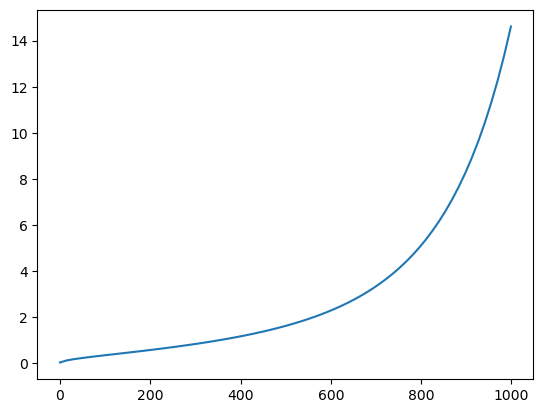

In [21]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1]);

#### Denoising

In [22]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
    # create 2 latents, one for the text prompt, and one for the unconditioned prompt
    input = torch.cat([latents] * 2)
    # scale the noise on the latents
    input = scheduler.scale_model_input(input, t)
    
    # predict the noise
    with torch.no_grad(): pred = unet(input, t, encoder_hidden_states=text_embeddings).sample
                                      
    # perform guidance
    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)
    
    # compute the "previous" noisy sample
    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

#### Decoding with the VAE

The `latents` now contain the denoised representation of the image, so all that's left to do is use our `vae` to decode it to our pixel image

In [23]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample

In [24]:
with torch.no_grad(): image_bad = vae.decode(1 / 0.125 * latents).sample

#### Displaying our Images with PIL

Now we just have to do a bit of wrangling to put our images in a format that PIL can read, and we're done!

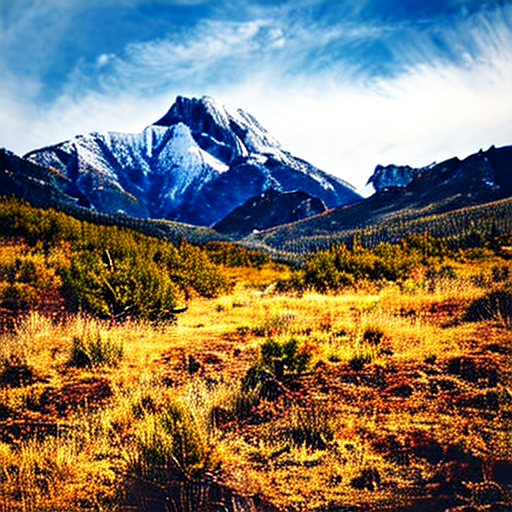

In [25]:
image_bad = (image_bad / 2 + 0.5).clamp(0,1)
image_bad = image_bad[0].detach().cpu().permute(1,2,0).numpy()
image_bad = (image_bad * 255).round().astype("uint8")
Image.fromarray(image_bad)

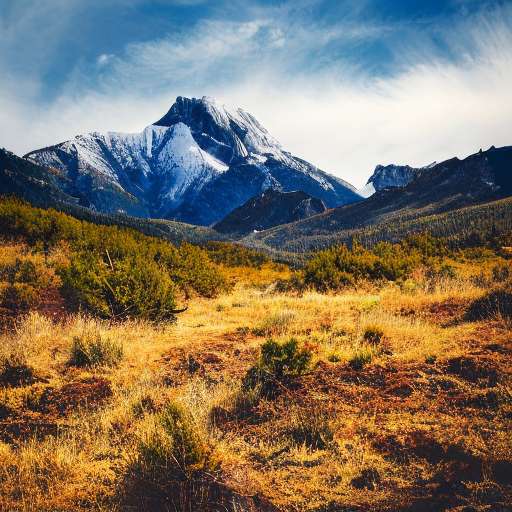

In [26]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)